In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama
import galpy
agama.setUnits( mass=1., length=1., velocity=1.)  # Msun, kpc, km/s

# Compare Potentials

In [2]:
from Cautun20 import C20_pot as a_C20
ini_C20 = agama.Potential('Cautun20.ini')
#Load from py or from ini file. Note ini file combines cgm and bulge as single spheroid potential, py gives seperate
a_M17 = agama.Potential("McMillan17.ini")
a_PW19 = agama.Potential("PriceWhelan19.ini")
a_MW14 = agama.Potential("MWPotential2014.ini")

def a_vcirc(pot,R):
    vc = np.sqrt(-R*pot.force(np.stack((R,np.zeros_like(R), np.zeros_like(R))).transpose())[:,0])

    return vc

def a_pot_R(pot,R):
    return pot.potential(np.stack((R,np.zeros_like(R), np.zeros_like(R))).transpose())

Load Pot


In [3]:
nR = 1000
R_space = np.geomspace(0.5, 200, nR)

a_Pots = {'C20':a_C20, 'M17':a_M17, 'PW19':a_PW19, 'MW14':a_MW14, 'ini_C20':ini_C20}
pots = list(a_Pots.keys())
a_vc = {p:a_vcirc(a_Pots[p], R_space) for p in pots}

In [4]:

MWVCircData=np.loadtxt('Eilers19_Vcirc.txt')
vdata_r=MWVCircData[:,0]
vdata_vc=MWVCircData[:,1]
vdata_vc_u=MWVCircData[:,2]
vdata_vc_l=MWVCircData[:,3]


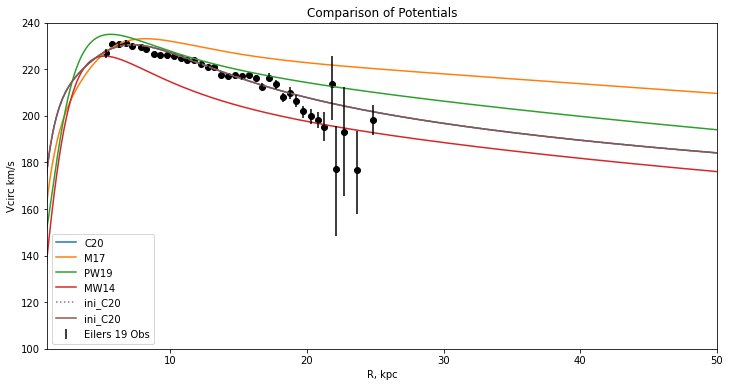

In [5]:
plt.figure(figsize=(12,6))
for p in pots:
    if p == 'ini_C20':
        plt.plot(R_space, a_vc[p], label=p, ls=':')
    else:
        plt.plot(R_space, a_vc[p], label=p)
plt.ylim([100, 240])
plt.plot(R_space, a_vc[p], label=p)
plt.errorbar(vdata_r, vdata_vc, yerr=[vdata_vc_u, vdata_vc_l], ls = 'none',
            label='Eilers 19 Obs', c='black')
plt.scatter(vdata_r, vdata_vc,c='black')
plt.xlim([1, 50])
plt.xlabel('R, kpc')
plt.ylabel('Vcirc km/s')
plt.title('Comparison of Potentials')
plt.legend()
plt.show()

In [6]:
components = ['DM_Halo','disc', 'bulge','cgm']
individual_components = ['thin','thick','HI','H2', 'bulge', 'cgm', 'DM_Halo']
print(a_C20)
a_C20_seperate = {com: a_C20[i] for (i,com) in enumerate(individual_components)}
a_C20_seperate['disc'] = agama.Potential(a_C20_seperate['thin'],a_C20_seperate['thick']
                                          ,a_C20_seperate['HI'],a_C20_seperate['H2'])

a_C20_vc_seperate = { com: a_vcirc(a_C20_seperate[com],R_space)
                     for com in components}


CompositePotential: CompositePotential, CompositePotential, CompositePotential, CompositePotential, Multipole, Multipole, Multipole


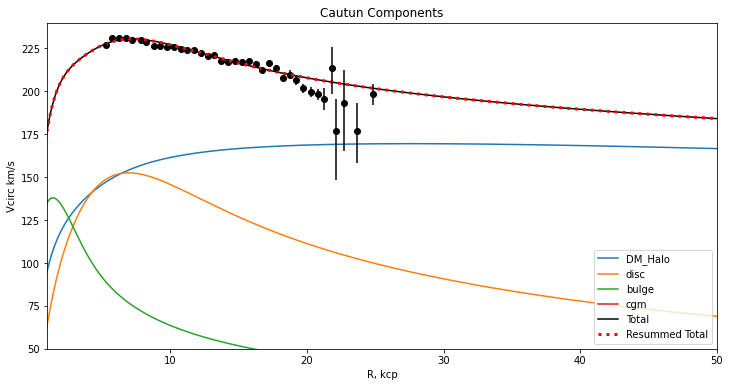

In [7]:

plt.figure(figsize=(12,6))
total_vc = np.zeros_like(a_vc['C20']**2)
for com in components:
    plt.plot(R_space, a_C20_vc_seperate[com], label=com)
    total_vc = total_vc  + (a_C20_vc_seperate[com]**2)
total_vc = np.sqrt(total_vc)

plt.plot(R_space, a_vc['C20'], label='Total', c='k')
plt.plot(R_space, total_vc, label='Resummed Total', c='red', ls = ':', linewidth=3)

plt.ylim([50, 240])
plt.errorbar(vdata_r, vdata_vc, yerr=[vdata_vc_u, vdata_vc_l], ls = 'none', c='black')
plt.scatter(vdata_r, vdata_vc,c='black')
plt.xlim([1, 50])
plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Cautun Components')
plt.legend()
plt.show()

# Compare with Galpy
Potential matches, with differences at the very centre (<1 kpc), and 0.1% difference towards R200.   
Implementation, or AGAMA vs Galpy difference?  
A similar difference can be seen in McMillan17 Potential.  
Hopefully not significant!

In [8]:
from galpy.potential.Cautun20 import Cautun20 as g_C20
from galpy.potential.mwpotentials import McMillan17 as g_M17
from galpy.potential import vcirc
g_vc_C20 = vcirc(g_C20,R=R_space/g_C20[0]._ro, use_physical=True)
g_vc_M17 = vcirc(g_M17,R=R_space/g_M17[0]._ro, use_physical=True)

/home/tom/miniconda3/lib/python3.9/site-packages/galpy-1.8.0.dev0-py3.9-linux-x86_64.egg/galpy/potential/AdiabaticContractionWrapperPotential.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Phi0= integrate.quad(new_rforce_func,rgrid[0],rgrid[-1])[0]\



In [9]:
components = ['DM_Halo','disc', 'bulge', 'cgm']
print(g_C20)
g_C20_seperate = { com: g_C20[i] for (i,com) in enumerate(components)}
g_C20_vc_seperate = { com: vcirc(g_C20_seperate[com],R=R_space/g_C20[0]._ro)
                     for com in components}


[<galpy.potential.AdiabaticContractionWrapperPotential.AdiabaticContractionWrapperPotential object at 0x7f26afc36be0>, <galpy.potential.DiskSCFPotential.DiskSCFPotential object at 0x7f26b73b1d60>, <galpy.potential.SCFPotential.SCFPotential object at 0x7f26b73b1ca0>, <galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x7f26b73b1cd0>]


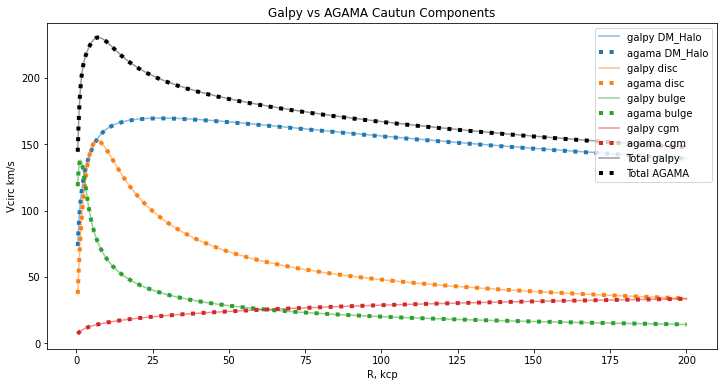

In [10]:


plt.figure(figsize=(12,6))
for com in components:
    p = plt.plot(R_space, g_C20_vc_seperate[com], label=f'galpy {com}',alpha=0.5)
    plt.plot(R_space, a_C20_vc_seperate[com], label=f'agama {com}', ls =':', c = p[0].get_color(),linewidth=4)

plt.plot(R_space, g_vc_C20, label='Total galpy', c='k',alpha=0.4)
plt.plot(R_space, a_vc['C20'], label='Total AGAMA', c='k', ls = ':', linewidth=4)

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA Cautun Components')
plt.legend()
plt.show()

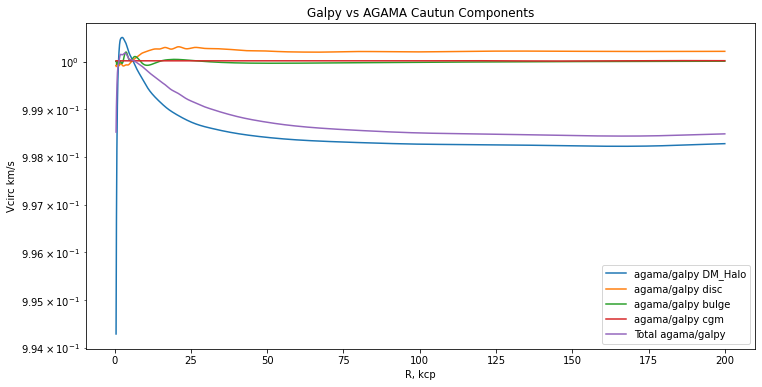

In [11]:


plt.figure(figsize=(12,6))
for com in components:
    plt.plot(R_space, a_C20_vc_seperate[com]/ g_C20_vc_seperate[com]
             , label=f'agama/galpy {com}')

plt.plot(R_space, a_vc['C20']/ g_vc_C20,
          label=f'Total agama/galpy ')

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA Cautun Components')
plt.yscale('log')
plt.legend()
plt.show()

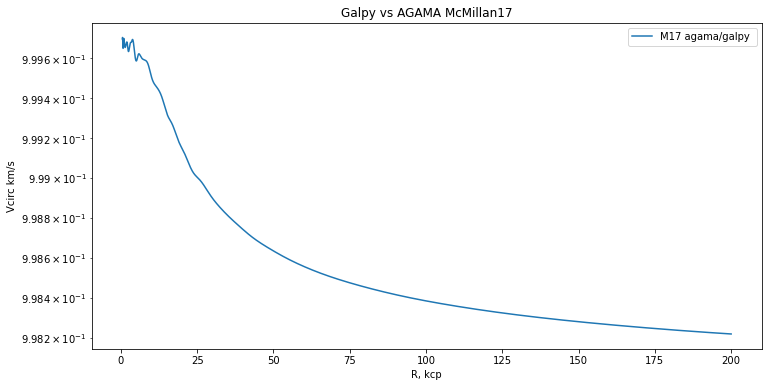

In [12]:
plt.figure(figsize=(12,6))
plt.plot(R_space, a_vc['M17']/ g_vc_M17,
          label=f'M17 agama/galpy ')

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA McMillan17')
plt.yscale('log')
plt.legend()
plt.show()

# Example Contraction
What would McMillan17 look like contracted?

In [13]:
from contraction_agama import contract_agama_potential
M17_uncontracted_DM_pot = agama.Potential(type="Spheroid",
                                        densityNorm = 8.53702e+06,
                                        axisRatioZ = 1,
                                        gamma = 1,
                                        beta = 3,
                                        scaleRadius = 19.5725)

M17_thin_disc_pot = agama.Potential( type = 'Disk',
                                surfaceDensity = 8.95679e+08,
                                scaleRadius = 2.49955,
                                scaleHeight = 0.3)

M17_thick_disc_pot = agama.Potential( type = "Disk",
                                    surfaceDensity = 1.83444e+08,
                                    scaleRadius = 3.02134,
                                    scaleHeight = 0.9)

M17_HI_disc_pot = agama.Potential( type = "Disk",
                                surfaceDensity = 5.31319e+07,
                                scaleRadius = 7,
                                scaleHeight = -0.085,
                                innerCutoffRadius = 4)

M17_H2_disc_pot = agama.Potential( type = "Disk",
                                surfaceDensity = 2.17995e+09,
                                scaleRadius = 1.5,
                                scaleHeight = -0.045,
                                innerCutoffRadius = 12)

M17_bulge_pot = agama.Potential(type="Spheroid",
                                densityNorm = 9.8351e+10,
                                axisRatioZ = 0.5,
                                gamma = 0,
                                beta = 1.8,
                                scaleRadius = 0.075,
                                outerCutoffRadius = 2.1)


M17_Baryon_pot = agama.Potential(M17_thin_disc_pot, M17_thick_disc_pot, M17_HI_disc_pot, 
                                M17_H2_disc_pot, M17_bulge_pot)
M17_contracted_dm_pot = contract_agama_potential(M17_uncontracted_DM_pot, M17_Baryon_pot)
contracted_M17_pot = agama.Potential(M17_contracted_dm_pot, M17_Baryon_pot)

/home/tom/.local/lib/python3.9/site-packages/agama-1.0-py3.9-linux-x86_64.egg/agama/py/pygama.py:21: RuntimeWarning: setUnits() called after creating instances of Potential and other classes may lead to incorrect scaling of input/output data in their methods
  return _setUnits(**args)  # call the setUnits(...) function from the C++ extension module

/home/tom/Scripts/Python/Miscellaneous/Agama_Cautun_Contraction/contraction_agama.py:30: RuntimeWarning: divide by zero encountered in log
  return np.exp(dens_contracted_interp(np.log(np.sum(xyz**2, axis=1))*0.5))



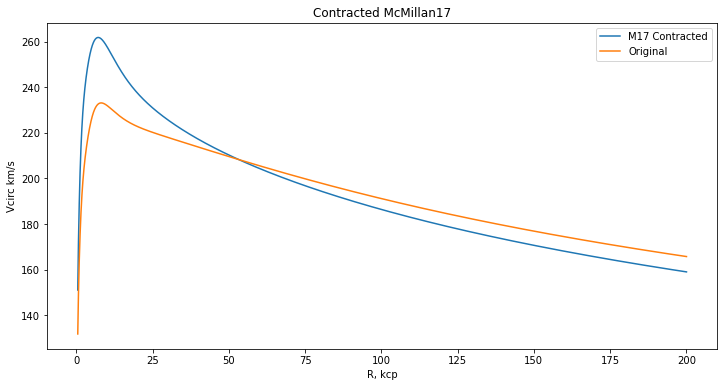

In [14]:
M17_vc_contracted = a_vcirc(contracted_M17_pot,R_space)
plt.figure(figsize=(12,6))

plt.plot(R_space, M17_vc_contracted, label='M17 Contracted')
plt.plot(R_space, a_vc['M17'], label='Original')

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Contracted McMillan17')
plt.legend()
plt.show()


# Agama Total Mass vs Scipy Integration
If agama is not the most recent version, totalMass method fails and required to integrate ourselves. A version of the script is tested below.

In [15]:

from contraction_agama import contract_density_fit, density_from_enclosed_mass, Mcum_from_axi_dens, Mcum_from_sph_dens
def scipy_contract_agama_potential(dm_pot, baryon_pot, fbar=0.157,rmax=500, rmin=0.1, scipy=False):
    '''Given spherical DM and axisymmetric baryon agama potentials,
    creates a contracted DM agama potential using procedure found in Cautun 20'''
    r_space =  np.geomspace(rmin,rmax,501)
    xyz = np.stack((r_space,np.zeros_like(r_space),np.zeros_like(r_space))).transpose()
    
    dens_dm = dm_pot.density(xyz)
    if not scipy:
        print('Agama totalMass')
        Mcum_dm = np.array([dm_pot.totalMass(r) for r in r_space])
        Mcum_bar = np.array([baryon_pot.totalMass(r) for r in r_space])
    else:
        print('scipy_integration')
        Mcum_dm = Mcum_from_sph_dens(r_space, dm_pot.density)
        Mcum_bar = Mcum_from_axi_dens(r_space, baryon_pot.density)
        
    dens_bar = density_from_enclosed_mass(r_space,Mcum_bar,r_space) #note spherical average
    dens_contracted = contract_density_fit(dens_dm,dens_bar,Mcum_dm,Mcum_bar,fbar)
    def contracted_dens_func(xyz):
        r = np.linalg.norm(xyz,axis=1)
        return np.interp(r, r_space, dens_contracted)

    contracted_pot = agama.Potential(type="Multipole", density=contracted_dens_func,
                                     symmetry="spherical", rmin=1e-3, rmax=1e3)
    return contracted_pot


In [16]:
M17_contracted_dm_pot = scipy_contract_agama_potential(M17_uncontracted_DM_pot, M17_Baryon_pot)
scipy_M17_contracted_dm_pot = scipy_contract_agama_potential(M17_uncontracted_DM_pot, M17_Baryon_pot, scipy=True)

Agama totalMass
scipy_integration
/home/tom/Scripts/Python/Miscellaneous/Agama_Cautun_Contraction/contraction_agama.py:128: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  shellMass[i] = integrate.quad( Int, 0., np.pi/2, args=( r[i], ) )[0] * dr[i]



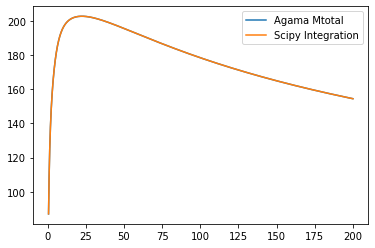

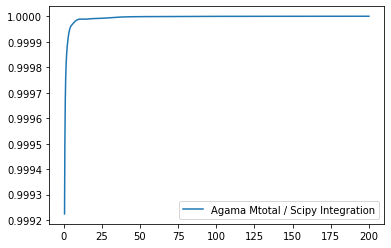

In [17]:
vc = a_vcirc(M17_contracted_dm_pot, R_space)
scipy_vc = a_vcirc(scipy_M17_contracted_dm_pot, R_space)
plt.figure()
plt.plot(R_space, vc, label='Agama Mtotal')
plt.plot(R_space, scipy_vc, label='Scipy Integration')
plt.legend()
plt.show()

plt.figure()
plt.plot(R_space, vc / scipy_vc, label='Agama Mtotal / Scipy Integration')
plt.legend()
plt.show()

# Alternate fbar

In [18]:
fb15_M17_contracted_dm_pot = contract_agama_potential(M17_uncontracted_DM_pot, M17_Baryon_pot,fbar=0.15)
contracted_M17_pot = agama.Potential(fb15_M17_contracted_dm_pot, M17_Baryon_pot)

fb12_M17_contracted_dm_pot = contract_agama_potential(M17_uncontracted_DM_pot, M17_Baryon_pot, fbar=0.12)
contracted_M17_pot = agama.Potential(fb12_M17_contracted_dm_pot, M17_Baryon_pot)

/home/tom/Scripts/Python/Miscellaneous/Agama_Cautun_Contraction/contraction_agama.py:30: RuntimeWarning: divide by zero encountered in log
  return np.exp(dens_contracted_interp(np.log(np.sum(xyz**2, axis=1))*0.5))



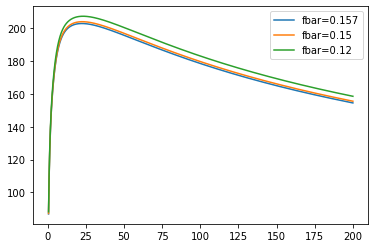

In [19]:
fb_vc = a_vcirc(M17_contracted_dm_pot, R_space)
fb15_vc = a_vcirc(fb15_M17_contracted_dm_pot, R_space)
fb12_vc = a_vcirc(fb12_M17_contracted_dm_pot, R_space)

plt.figure()
plt.plot(R_space, fb_vc, label='fbar=0.157')
plt.plot(R_space, fb15_vc, label='fbar=0.15')
plt.plot(R_space, fb12_vc, label='fbar=0.12')
plt.legend()
plt.show()